In [1]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
from scipy.stats import gmean
import cv2
import matplotlib.pyplot as plt

# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [2]:
image= "/home/casper/Documents/Aardwetenschappen/MSc Thesis/Photo/08_07_22/Dried/Location_6_2.jpg"
resolution = 0.0377118644067797
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)
maxscale= width*resolution / 8

x= 0
verbose = 1

im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

filter=False

if filter:
    sigma_est = estimate_sigma(im, multichannel=False, average_sigmas=True)
    region = denoise_wavelet(im, multichannel=False, rescale_sigma=True,
                                method='VisuShrink', mode='soft', sigma=sigma_est*2)
else:
    region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape


Testing

In [7]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1), np.maximum(nx,ny)/(width*resolution / .9), 1),  'cmor10-2', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_1 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_1-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_1, np.mean(M), srt/2)
p = np.hstack([p])
scales_1 = np.hstack([scales_1])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_1 = (p*scales_1**x) / np.sum(p*scales_1**x) #volume-by-weight proportion

In [17]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 1), np.maximum(nx,ny)/(width*resolution / 3.9), 1),  'cmor10-6', .5) #cmor10-1.1
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_2 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_2-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_2, np.mean(M), srt/2)
p = np.hstack([p])
scales_2 = np.hstack([scales_2])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_2 = (p*scales_2**x) / np.sum(p*scales_2**x) #volume-by-weight proportion


In [21]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 4), np.maximum(nx,ny)/(width*resolution / 20), 1),  'cmor10-6', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_3 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_3-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_3, np.mean(M), srt/2)
p = np.hstack([p])
scales_3 = np.hstack([scales_3])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_3 = (p*scales_3**x) / np.sum(p*scales_3**x) #volume-by-weight proportion

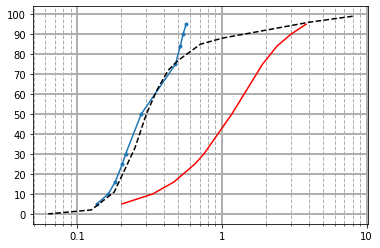

In [20]:
r_v_T = np.concatenate((r_v_1, r_v_2, r_v_3))
r_v_T = r_v_T / 3
scales_T = np.concatenate((scales_1, scales_2, scales_3))

pd_T = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_T))), np.hstack((0,scales_T)) ) * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_data_6 = [99,96,92,88,85,77,72,62,50,33,11,2,0]

percentiles = [5, 10, 16, 25, 30, 50, 75, 84, 90, 95] 

dgs_data = [0.20363479, 0.332422745, 0.465360763, 0.649031694, 0.749169018, 1.168365485, 1.907612333, 2.395047588, 2.99679224, 3.80914593]
plt.plot(pd_T, percentiles, marker='.')
plt.plot(sieve_open, sieve_data_6, ls='--', color='black')
plt.plot(dgs_data, percentiles, color='red')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()